In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from time import time
import datetime
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve,GridSearchCV

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
mnist = keras.datasets.mnist

Comienzo el ejercicio cargando los datasets desde Tensorflow. Según la documentación del Dataset, se hace una carga de Arrays y se generan 4 variables (features y variable objetivo tanto en train como en test) ya que la información viene contenida en formato de tuplas. 

In [ ]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
(x_train_fashion, y_train_fashion), (x_test_fashion,y_test_fashion) = fashion_mnist.load_data()

Como segundo paso observo cómo está compuesto un objeto de cada Dataframe para entender la información que contienen. 

Para esto, utilizo imshow del paquete de matplotlib el cual se encarga de generar imágenes con base en la información del array (según un patrón de RGB, por ejemplo).

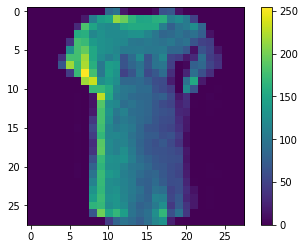

In [ ]:
plt.figure()
plt.imshow(x_train_fashion[600])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
print("Largo de todo el dataset de fashion mnist TRAIN: {}".format(len(x_train_fashion)))
print("Largo del array: {}".format(len(x_train_fashion[600])))
print("Largo del primer objeto del array: {}".format(len(x_train_fashion[600][1])))

Largo de todo el dataset de fashion mnist TRAIN: 60000
Largo del array: 28
Largo del primer objeto del array: 28


Lo que quiere decir lo anterior es que dentro del dataset de fashion mnist se encuentran 60000 items. Dentro de cada uno de los mismos, a su vez, se componen arrays de 28 x 28 pixeles donde se informa la escala de color.

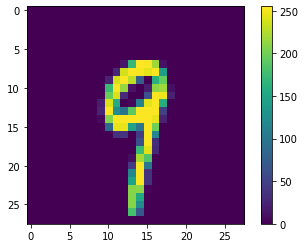

In [ ]:
plt.figure()
plt.imshow(x_train_mnist[600])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
print("Largo de todo el dataset de mnist TRAIN: {}".format(len(x_train_mnist)))
print("Largo del array: {}".format(len(x_train_mnist[600])))
print("Largo del primer objeto del array: {}".format(len(x_train_mnist[600][1])))

Largo de todo el dataset de mnist TRAIN: 60000
Largo del array: 28
Largo del primer objeto del array: 28


Se puede observar que ambos datasets están compuestos por representaciones de imágenes, en formato unidimensional, que refieren a números del 0 al 9 (en el caso de mnist) y de distintos tipos de ropa (en el caso de fashion mnist).

In [ ]:
#Observación del número de clases que hay para cada dataset

print("Valores únicos de clase para fashion mnist: {}, \nTotal de clases: {}".format(np.unique(y_train_fashion),
                                                                           len(np.unique(y_train_fashion))))

print("\nValores únicos de clase para mnist: {}, \nTotal de clases: {}".format(np.unique(y_train_mnist),
                                                                           len(np.unique(y_train_mnist))))

Valores únicos de clase para fashion mnist: [0 1 2 3 4 5 6 7 8 9], 
Total de clases: 10

Valores únicos de clase para mnist: [0 1 2 3 4 5 6 7 8 9], 
Total de clases: 10


# Reducción de dimensionalidad para los datasets

Comienzo generando subconjuntos de test y train con los datasets ya disponibles.

In [ ]:
#Conversión set MNIST

Xtrain_mnist, Xtest, Ytrain_mnist, Ytest = train_test_split(x_train_mnist, y_train_mnist, test_size=(4/6), random_state=420)

#Largo del dataset de entrenamiento de acuerdo a lo solicitado en el ejercicio
print(len(Xtrain_mnist))
print(len(Ytrain_mnist))

#Elimino los sets de test ya que utilizaré el otro DF completo.
del Xtest
del Ytest

20000
20000


A partir de la explicación anterior, donde se comentaba que los dataset estaban compuestos por elementos que tenían (dentro de cada uno de ellos) una forma de 28 elementos con 28 elementos anidados, procedo a generar un array unidimensional donde cada elemento esté representado únicamente por un array.

In [ ]:
Xtrain_mnist = np.reshape(np.array(Xtrain_mnist), (20000, 28*28))
x_test_mnist = np.reshape(np.array(x_test_mnist), (10000, 28*28))

print("Forma de array de entrenamiento: {} \nForma de array de testing: {}".format(np.shape(Xtrain_mnist), np.shape(x_test_mnist)))

Forma de array de entrenamiento: (20000, 784) 
Forma de array de testing: (10000, 784)


Antes de comenzar a realizar el PCA, estandarizo el set de datos (media 0 y desviación típica 1 de los datos) para mejorar el procesamiento de cálculo de los algoritmos de clasificación.

Para efectuar la reducción de dimensionalidad paso a generar un PCA que permita comprimir las imágenes y, por lo tanto, minimizar la cantidad de features de los dataframes. El punto clave en esta reducción radicará entonces en que la varianza se encuentra en la mayor medida de los posible correctamente explicada por el PCA generado.

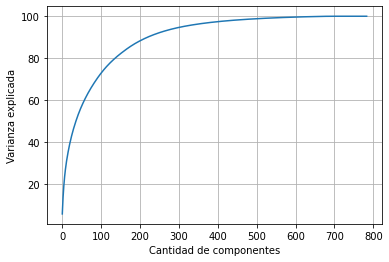

In [ ]:
#Genero un PCA con el total de features para ver la varianza acumulada explicada en el PCA dependiendo la cantidad de componentes.

scaler = StandardScaler()
x_standared_mnist = scaler.fit_transform(Xtrain_mnist)

pca_784 = PCA(n_components=784)
pca_784.fit(x_standared_mnist)

plt.grid()
plt.plot(np.cumsum(pca_784.explained_variance_ratio_ * 100))
plt.xlabel('Cantidad de componentes')
plt.ylabel('Varianza explicada')
plt.show()

Al generar el PCA con el total de componentes e ir viendo la evolución de la varianza explicada, tomo como 200 el número de componentes óptimos que permitirán reducir la dimensionalidad sin afectar la calidad de la información.

In [ ]:
pca_200_mnist = PCA(n_components=200)

#Nuevo dataset de training con PCA y estandarización

mnist_pca_200_reduced = pca_200_mnist.fit_transform(x_standared_mnist)

#Para volver al tipo de datos original, procedo a hacer una inverse transform del PCA y, posteriormente, de la standarización.

mnist_pca_200_recovered = scaler.inverse_transform(pca_200_mnist.inverse_transform(mnist_pca_200_reduced))

Una vez generada la reducción, se puede ver debajo que el resultado es satisfactorio. Al reducir la dimensionalidad, la imagen aún así se mantiene distinguible.

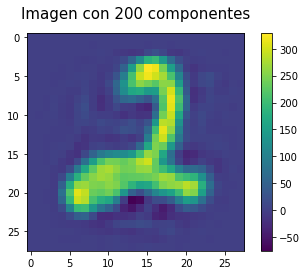

In [ ]:
image_pca_10 = mnist_pca_200_recovered[600].reshape([28,28])
plt.imshow(image_pca_10)
plt.colorbar()
plt.title('Imagen con 200 componentes', fontsize=15, pad=15)
plt.show()

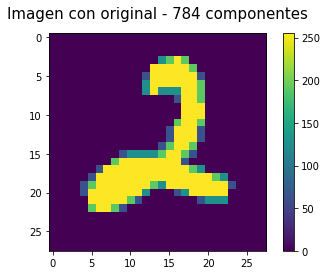

In [ ]:
plt.imshow(Xtrain_mnist[600].reshape([28,28]))
plt.colorbar()
plt.title('Imagen con original - 784 componentes', fontsize=15, pad=15)
plt.show()

Repito los mismos pasos, para el set de Fashion MNIST.

In [ ]:
#Conversión Fashion MNIST

Xtrain_fashion, Xtest, Ytrain_fashion, Ytest = train_test_split(x_train_fashion, y_train_fashion, test_size=(4/6), random_state=420)

#Largo del dataset de entrenamiento de acuerdo a lo solicitado en el ejercicio
print(len(Xtrain_fashion))
print(len(Ytrain_fashion))

#Elimino los sets de test ya que utilizaré el otro DF completo.
del Xtest
del Ytest

20000
20000


In [ ]:
Xtrain_fashion = np.reshape(np.array(Xtrain_fashion), (20000, 28*28))
x_test_fashion = np.reshape(np.array(x_test_fashion), (10000, 28*28))

print("Forma de array de entrenamiento: {} \nForma de array de testing: {}".
      format(np.shape(Xtrain_fashion), np.shape(x_test_fashion)))

Forma de array de entrenamiento: (20000, 784) 
Forma de array de testing: (10000, 784)


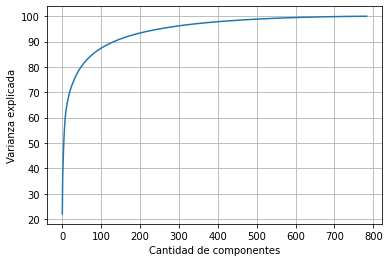

In [ ]:
#Genero un PCA con el total de features para ver la varianza acumulada explicada en el PCA dependiendo la cantidad de componentes.


scaler = StandardScaler()
x_standared = scaler.fit_transform(Xtrain_fashion)


pca_784 = PCA(n_components=784)
pca_784.fit(x_standared)

plt.grid()
plt.plot(np.cumsum(pca_784.explained_variance_ratio_ * 100))
plt.xlabel('Cantidad de componentes')
plt.ylabel('Varianza explicada')
plt.show()

Se puede observar que, a diferencia de el set MNIST, en este caso se requerirán mas componentes para continuar explicando la varianza en un valor aceptable. A pesar de lo anterior, decido tomar 200 componentes a efectos de comparabilidad. 

In [ ]:
pca_200_fashionmnist = PCA(n_components=200)

#Nuevo dataset de training con PCA y estandarización

fashionmnist_pca_200_reduced = pca_200_fashionmnist.fit_transform(x_standared)

#Para volver al tipo de datos original, procedo a hacer una inverse transform del PCA y, posteriormente, de la standarización.

fashionmnist_pca_200_recovered = scaler.inverse_transform(pca_200_fashionmnist.inverse_transform(fashionmnist_pca_200_reduced))

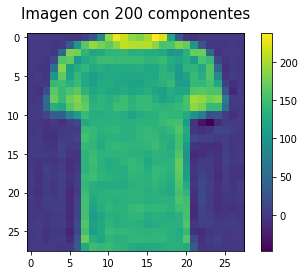

In [ ]:
image_pca_10 = fashionmnist_pca_200_recovered[100].reshape([28,28])
plt.imshow(image_pca_10)
plt.colorbar()
plt.title('Imagen con 200 componentes', fontsize=15, pad=15)
plt.show()

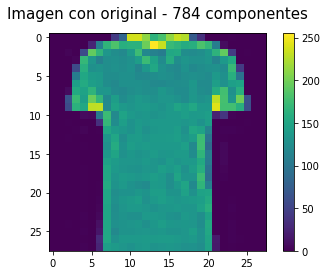

In [ ]:
plt.imshow(Xtrain_fashion[100].reshape([28,28]))
plt.colorbar()
plt.title('Imagen con original - 784 componentes', fontsize=15, pad=15)
plt.show()

Una vez generados ambos PCA, continúo utilzándolos como bases de trabajo para minimizar los tiempos computacionales.

# Modelo SVM para dataset MNIST


Como primer paso para el modelo con kerneal lineal, procedo a genera un gridsearch para encontrar el parámetro C óptimo.

Para el modelo mnist voy a utilizar dos tipos de datos: para el modelo con kernel lineal utilizaré los datos tal y como están (sin escalar ni dimensionalidad reducida) mientras que para el kernel gausiano usaré el PCA. 

El motivo de esta decisión es por los tiempos de cómputos de los modelos y buscar la mejor alternativa para este objetivo didáctico.

In [ ]:
parameters = [{'kernel': ['linear'], 'C': [1, 10, 100, 1000],  'probability': [False], 'gamma': ['scale']}]

timeIni = time()
grid = GridSearchCV(SVC(), parameters)
grid.fit(Xtrain_mnist, Ytrain_mnist)
timeEnd = time()
timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

print("La mejor parametrización para la SVM (en el conjunto de training) es: ", grid.best_params_)
print("Tiempo necesario para su cómputo: ", timeDiff)

La mejor parametrización para la SVM (en el conjunto de training) es:  {'C': 1, 'gamma': 'scale', 'kernel': 'linear', 'probability': False}
Tiempo necesario para su cómputo:  08:41:756004


A partir de la búsqueda grid que se hizo, el parámetro C ideal parece ser 1 para optimizar el modelo. 

Con lo anterior en mente, genero una iteración para cada valor de C con el fin de conocer mejor los valores devueltos por cada uno de los modelos al hacer fit sobre los datos de testing. 

En una primera instancia, genero el PCA también en los datos de test para que puedan ser utilizados en el modelo.

In [ ]:
minAcc = 100
maxAcc = 0
rapidoAcc = 0
lentoAcc = 0
mejorTime = 0
peorTime = 0
minTime = 1000000000
maxTime = 0

mejorModelo = SVC()
peorModelo = SVC()
rapidoModelo = SVC()
lentoModelo = SVC()


kernel = "linear"

for c in (1, 10, 100, 1000):
  print("Kernel lineal con C=", c)
  
  timeIni = time()
  modelo = SVC(kernel = kernel, C=c, probability = False, gamma = "scale").fit(Xtrain_mnist,Ytrain_mnist)
  print(modelo)
  timeEnd = time()
  timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

  acc = modelo.score(x_test_mnist, y_test_mnist)
  print("Precisión (accuracy): ", acc)
  print("Tiempo entrenamiento: ", timeDiff)

  predicciones = modelo.predict(x_test_mnist)
  print("Matriz de confusión:")
  print(confusion_matrix(y_test_mnist, predicciones))
  print(classification_report(y_test_mnist, predicciones))
  print("---------------------------------------")
  print()


Kernel lineal con C= 1
SVC(C=1, kernel='linear')
Precisión (accuracy):  0.9148
Tiempo entrenamiento:  00:39:837258
Matriz de confusión:
[[ 961    0    2    2    1    5    8    1    0    0]
 [   0 1121    1    2    0    1    3    0    7    0]
 [  17    6  948   14   10    0   12    7   17    1]
 [   7    5   15  895    2   37    3   13   29    4]
 [   5    1    5    1  929    0    7    1    2   31]
 [  16    6   11   48    7  756    8    2   32    6]
 [  11    2   15    1    4   17  905    1    1    1]
 [   1    5   21    7    9    0    0  943    4   38]
 [   7   13   21   56   11   28    6    9  818    5]
 [  10    8    2    9   61    6    0   34    7  872]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.96      0.99      0.97      1135
           2       0.91      0.92      0.91      1032
           3       0.86      0.89      0.88      1010
           4       0.90      0.95      0.92       982
        

Como se puede ver a partir de lo generado anteriormente, los valores de precision/recall no cambian a medida que C se aumenta. 

Dado lo anterior, y con el fin de prevenir un posible overfitting, decido mantener la decisión anterior que indicaba que el parámetro C óptimo del modelo lineal es C=1.

Una vez encontrado el modelo lineal óptimo, paso a realizar uno gausiano. Para el modelo gausiano procederé primero con el escalado y PCA del set de testing para poder ser comparado en la matriz de confusión.

In [ ]:

#X test estandarizada
x_test_standared_mnist = scaler.fit_transform(x_test_mnist)

#Test data con PCA (Componentes = 200)
testmnist_pca_200_reduced = pca_200_mnist.fit_transform(x_test_standared_mnist)


In [ ]:
parameters = [{'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'probability': [False], 'gamma': ['scale']}]

timeIni = time()
grid = GridSearchCV(SVC(), parameters)
grid.fit(mnist_pca_200_reduced, Ytrain_mnist)
timeEnd = time()
timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

print("La mejor parametrización para la SVM (en el conjunto de training) es: ", grid.best_params_)
print("Tiempo necesario para su cómputo: ", timeDiff)

La mejor parametrización para la SVM (en el conjunto de training) es:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'probability': False}
Tiempo necesario para su cómputo:  05:02:916702


In [ ]:
kernel = "rbf"

for c in (1, 10, 100, 1000):
 
  print("Kernel Gaussiano con C=", c)
  timeIni = time()
  modelo = SVC(kernel = kernel , C=c).fit(mnist_pca_200_reduced,Ytrain_mnist)
  print(modelo.fit(mnist_pca_200_reduced,Ytrain_mnist))
  timeEnd = time()
  timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

  acc = modelo.score(testmnist_pca_200_reduced, y_test_mnist)
  print("Precisión (accuracy): ", acc)
  print("Tiempo entrenamiento: ", timeDiff)

  predicciones = modelo.predict(testmnist_pca_200_reduced)
  print("Matriz de confusión:")
  print(confusion_matrix(y_test_mnist, predicciones))
  print(classification_report(y_test_mnist, predicciones))
  print("---------------------------------------")
  print()


Kernel Gaussiano con C= 1
SVC(C=1)
Precisión (accuracy):  0.5934
Tiempo entrenamiento:  00:29:324873
Matriz de confusión:
[[801   0  28   4   4  62  19   9  50   3]
 [  1 875  22  24  59  41   7  11  93   2]
 [ 34  10 651  17  33  14  76  31 165   1]
 [ 26  16  95 511   3 140   7  40 163   9]
 [  6   3  91  19 325   0  27  80  81 350]
 [ 16   8  39 171   8 356  11 189  75  19]
 [ 74   3 110  12   3  48 669  36   2   1]
 [  1  16  14 110  23   1   1 728  24 110]
 [ 25   0  68  98  32  37   5  61 607  41]
 [  7   4  27  39 274   9   1 205  32 411]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       980
           1       0.94      0.77      0.85      1135
           2       0.57      0.63      0.60      1032
           3       0.51      0.51      0.51      1010
           4       0.43      0.33      0.37       982
           5       0.50      0.40      0.45       892
           6       0.81      0.70      0.75       958
           7  

Para el modelo gausiano solamente he modificado el parámetro C (al igual que en el lineal) para mejorar el tiempo computacional que requerirá el modelo.

En cualquiera de los casos, se puede notar que los modelos con kernel lineal mejoran no solo la accurracy general del modelo sino que también lo hace para cada label junto a su correspondiente recall.

En tiempos de cómputo, se puede notar que ambos kernel demoran aproximadamente lo mismo (aprox 20 minutos). Para la situación particular de este ejercicio decido tomar el modelo con kernel lineal con C=1 debido a su mejora en precision/recall y manteniendo baja la posibilidad de overfitting. 

# Modelo SVM para dataset Fashion MNIST

El set de datos Fashion MNIST posee mayor complejidad en su procesamiento y, por lo tanto, consume muchos recursos a la hora de ser modelizado. Dada la situación anterior, utilizaré para ambos kernel la versión estandarizada y con PCA de los datasets.

In [ ]:
# Set de testing estandarizado
x_test_standared_fashion = scaler.fit_transform(x_test_fashion)

# PCA con 200 componentes
testfashionmnist_pca_200_reduced = pca_200_fashionmnist.fit_transform(x_test_standared_fashion)

In [ ]:
parameters = [{'kernel': ['linear'], 'C': [1, 10 ],  'probability': [False], 'gamma': ['scale']}]

timeIni = time()
grid = GridSearchCV(SVC(), parameters)
grid.fit(fashionmnist_pca_200_reduced, Ytrain_fashion)
timeEnd = time()
timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

print("La mejor parametrización para la SVM (en el conjunto de training) es: ", grid.best_params_)
print("Tiempo necesario para su cómputo: ", timeDiff)

La mejor parametrización para la SVM (en el conjunto de training) es:  {'C': 1, 'gamma': 'scale', 'kernel': 'linear', 'probability': False}
Tiempo necesario para su cómputo:  41:52:009838


In [ ]:
kernel = "linear"

for c in (1, 10):
  print("Kernel lineal con C=", c)
  
  timeIni = time()
  modelo = SVC(kernel = kernel, C=c).fit(fashionmnist_pca_200_reduced,Ytrain_fashion)
  print(modelo)
  timeEnd = time()
  timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

  acc = modelo.score(testfashionmnist_pca_200_reduced, y_test_fashion)
  print("Precisión (accuracy): ", acc)
  print("Tiempo entrenamiento: ", timeDiff)

  predicciones = modelo.predict(testfashionmnist_pca_200_reduced)
  print("Matriz de confusión:")
  print(confusion_matrix(y_test_fashion, predicciones))
  print(classification_report(y_test_fashion, predicciones))
  print("---------------------------------------")

Kernel lineal con C= 1
SVC(C=1, kernel='linear')
Precisión (accuracy):  0.5891
Tiempo entrenamiento:  01:09:944016
Matriz de confusión:
[[640  12  48 137  27   3 108   0  25   0]
 [ 42 895   9  41   5   0   6   0   2   0]
 [ 69   4 475  19 156   1 265   0  11   0]
 [170 157  66 543  19   0  35   0  10   0]
 [ 12   5 253 129 466   0 125   0  10   0]
 [  0   0   1   2   0 664   2 246   4  81]
 [199   9 269 125 163   1 198   0  36   0]
 [  0   0   0   0   0 308   0 629   8  55]
 [ 41   1  71  31  37  50  55  36 674   4]
 [  5   0   0   0   0 181   2 104   1 707]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59      1000
           1       0.83      0.90      0.86      1000
           2       0.40      0.47      0.43      1000
           3       0.53      0.54      0.54      1000
           4       0.53      0.47      0.50      1000
           5       0.55      0.66      0.60      1000
           6       0.25      0.20      0.22      1000


Modelos generados con Kernel Gausiano:

In [ ]:
parameters = [{'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'probability': [False], 'gamma': ['scale']}]

timeIni = time()
grid = GridSearchCV(SVC(), parameters)
grid.fit(fashionmnist_pca_200_reduced, Ytrain_fashion)
timeEnd = time()
timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

print("La mejor parametrización para la SVM (en el conjunto de training) es: ", grid.best_params_)
print("Tiempo necesario para su cómputo: ", timeDiff)

La mejor parametrización para la SVM (en el conjunto de training) es:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'probability': False}
Tiempo necesario para su cómputo:  05:19:914876


In [ ]:
kernel = "rbf"

for c in (1, 10, 100, 1000):
    print("Kernel Gaussiano con con C=", c)
    timeIni = time()
    modelo = SVC(kernel = kernel , C=c).fit(fashionmnist_pca_200_reduced,Ytrain_fashion)
    print(modelo.fit(fashionmnist_pca_200_reduced,Ytrain_fashion))
    timeEnd = time()
    timeDiff = datetime.datetime.fromtimestamp(timeEnd-timeIni).strftime("%M:%S:%f")

    acc = modelo.score(testfashionmnist_pca_200_reduced, y_test_fashion)
    print("Precisión (accuracy): ", acc)
    print("Tiempo entrenamiento: ", timeDiff)

    predicciones = modelo.predict(testfashionmnist_pca_200_reduced)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test_fashion, predicciones))
    print(classification_report(y_test_fashion, predicciones))
    print("---------------------------------------")
    print()

Kernel Gaussiano con con C= 1
SVC(C=1)
Precisión (accuracy):  0.7449
Tiempo entrenamiento:  00:27:214196
Matriz de confusión:
[[738   0  18 125   3   1  92   0  23   0]
 [ 15 905  12  52   8   0   6   0   2   0]
 [  8   0 635  16 182   0 150   0   9   0]
 [ 32  16  20 866   8   1  53   0   4   0]
 [  0   1 154  74 635   0 126   0  10   0]
 [  0   0   0   3   0 657   1 266  12  61]
 [163   0 217  97 126   1 357   0  39   0]
 [  0   0   0   0   0  96   0 847   4  53]
 [  0   1   2  11   7   8  19   7 943   2]
 [  0   0   1   1   0  30   0  79  23 866]]
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      1000
           1       0.98      0.91      0.94      1000
           2       0.60      0.64      0.62      1000
           3       0.70      0.87      0.77      1000
           4       0.66      0.64      0.64      1000
           5       0.83      0.66      0.73      1000
           6       0.44      0.36      0.40      1000
          

A partir de los modelos generados anteriormente se puede notar que la mejor opción sería por la familia de kernel gausianos. A su vez, el grid search recomienda un C= 10 mientras que en el loop realizado, se puede ver que C= 1 tiene un rendimiento aceptable.

A partir de lo anterior, decido utilizar el modelo kernel gausiano con c=1.

# Cruce modelos: MNIST y Fashion MNIST

Como último paso, voy a utilizar el modelo elegido en mnist para predecir 5000 de fashion mnist y viceversa para, de esta forma, ver el poder de generalización de los modelos.

In [ ]:
#Modelo mnist aplicado a fashion mnist

modelo = SVC(kernel = "linear", C= 1).fit(Xtrain_mnist, Ytrain_mnist)
acc = modelo.score(x_test_fashion, y_test_fashion)
print("Precisión (accuracy): ", acc)
predicciones = modelo.predict(x_test_fashion)
print("Matriz de confusión:")
print(confusion_matrix(y_test_fashion, predicciones))
print(classification_report(y_test_fashion, predicciones))
print("---------------------------------------")

Precisión (accuracy):  0.1349
Matriz de confusión:
[[  2   0  73 810   1  91   1   3  15   4]
 [  9   2 212 751   0  13   0   0  12   1]
 [  3   0 392 470   0 130   0   0   4   1]
 [  1   2 116 735   1 101   7   0  19  18]
 [  7   0 591 358   0  30   1   1   7   5]
 [175   0 392  24 155 211  30  11   2   0]
 [  1   0 313 559   0 110   1   0   8   8]
 [ 28   0 795   0 139  15  17   6   0   0]
 [ 17   0 527  33   6 321  91   2   0   3]
 [ 27   0 594  42   0 335   0   1   1   0]]
              precision    recall  f1-score   support

           0       0.01      0.00      0.00      1000
           1       0.50      0.00      0.00      1000
           2       0.10      0.39      0.16      1000
           3       0.19      0.73      0.31      1000
           4       0.00      0.00      0.00      1000
           5       0.16      0.21      0.18      1000
           6       0.01      0.00      0.00      1000
           7       0.25      0.01      0.01      1000
           8       0.00      0.

Se puede notar que el modelo funciona muy mal cuando se aplica a un set de datos que siguen distintos patrones. Esto tiene sentido ya que el modelo aprendió solamente patrones relacionados a números y no a vestimenta. A su vez, en el caso de que los valores de precision/recall fueran mejores, su interpretabilidad es nula ya que los labels de uno y otro dataset significan distintas cosas.

Por último, se ve una alta baja de precision general del modelo en comparación con el set de datos de testing del modelo original (0.9148 vs 0.1349 en comparación).

In [ ]:
#Modelo fashion mnist aplicado a mnist

modelo = SVC(kernel = "rbf" , C=10 ).fit(fashionmnist_pca_200_reduced,Ytrain_fashion)
acc = modelo.score(testmnist_pca_200_reduced, y_test_mnist)
print("Precisión (accuracy): ", acc)
predicciones = modelo.predict(testmnist_pca_200_reduced)
print("Matriz de confusión:")
print(confusion_matrix(y_test_mnist, predicciones))
print(classification_report(y_test_mnist, predicciones))
print("---------------------------------------")

Precisión (accuracy):  0.1071
Matriz de confusión:
[[258  27 212 158  49   0 244   0  32   0]
 [403   7  30 196   4   0 490   0   5   0]
 [171   1 152 209  60   0 253   0 185   1]
 [ 21  82 422  87 133   0 136   2 124   3]
 [ 12   1  44  75  38 126   7  10 570  99]
 [ 65  47  72 142 215   0 162   2 162  25]
 [ 96  17 173 172 117   7 163   0 139  74]
 [ 39   0  69  52   3  80  56 118 429 182]
 [ 17  16 182 234 228   2 189   5  93   8]
 [  4   0  54  32  61 182  18 155 348 155]]
              precision    recall  f1-score   support

           0       0.24      0.26      0.25       980
           1       0.04      0.01      0.01      1135
           2       0.11      0.15      0.12      1032
           3       0.06      0.09      0.07      1010
           4       0.04      0.04      0.04       982
           5       0.00      0.00      0.00       892
           6       0.09      0.17      0.12       958
           7       0.40      0.11      0.18      1028
           8       0.04      0.

Al igual que en el caso anterior, se observa que el modelo generado para fashion mnist no es extrapolable para mnist.